In [1]:
# !pip install pycocotools
# !pip install layoutparser
# !pip install "layoutparser[effdet]"
# # !pip install layoutparser torchvision
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# #!pip install layoutparser torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
# !pip install "layoutparser[paddledetection]"
# !pip install "layoutparser[ocr]"

In [ ]:
# !pip install "git+https://github.com/facebookresearch/detectron2.git"

In [3]:
# !pip install "git+https://github.com/Layout-Parser/layout-model-training.git"

  Cloning https://github.com/Layout-Parser/layout-model-training.git to c:\users\shallow\appdata\local\temp\pip-req-build-fkuvgeys
  Resolved https://github.com/Layout-Parser/layout-model-training.git to commit b9fad076596272e427612d5e848da1ba8ea06b97


  Running command git clone --filter=blob:none --quiet https://github.com/Layout-Parser/layout-model-training.git 'C:\Users\Shallow\AppData\Local\Temp\pip-req-build-fkuvgeys'
ERROR: git+https://github.com/Layout-Parser/layout-model-training.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [1]:
from pycocotools.coco import COCO
import numpy as np
import json
import os
import layoutparser as lp
import matplotlib.pyplot as plt
import random
import cv2
# os.chdir('/Users/shawnyang/Desktop/UofT/Work Study/My_work/NLP-Project-main/New_task/project-2-at-2024-11-16-22-19-c9fbe515')

In [2]:
def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotations for the current image
        coco('optional', defaults to 'False'):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout

In [3]:
# Paths

ORIGINAL_ANNOTATION = "new-project-2-at-2025-03-10-15-35-baa0e75e/result.json"
IMAGE_DIR = "new-project-2-at-2025-03-10-15-35-baa0e75e/images"

# Load
coco = COCO(ORIGINAL_ANNOTATION)
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
print("Categories:", cats)
print("Number of classes:", len(cats))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Categories: [{'id': 0, 'name': 'Abstract'}, {'id': 1, 'name': 'Author'}, {'id': 2, 'name': 'Context'}, {'id': 3, 'name': 'Header'}, {'id': 4, 'name': 'Image'}, {'id': 5, 'name': 'Reference'}, {'id': 6, 'name': 'Sub_title'}, {'id': 7, 'name': 'Table'}, {'id': 8, 'name': 'Title'}]
Number of classes: 9


In [4]:

# Validate images folder
if os.path.exists(IMAGE_DIR):
    all_files = os.listdir(IMAGE_DIR)
    print(f"Image directory '{IMAGE_DIR}' exists with {len(all_files)} files.")
else:
    raise FileNotFoundError(f"Directory '{IMAGE_DIR}' does not exist!")

Image directory 'new-project-2-at-2025-03-10-15-35-baa0e75e/images' exists with 167 files.


In [5]:
import layoutparser as lp
from PIL import Image

print("LayoutParser version:", lp.__version__)
print("Pillow version:", Image.__version__)

LayoutParser version: 0.3.4
Pillow version: 9.2.0


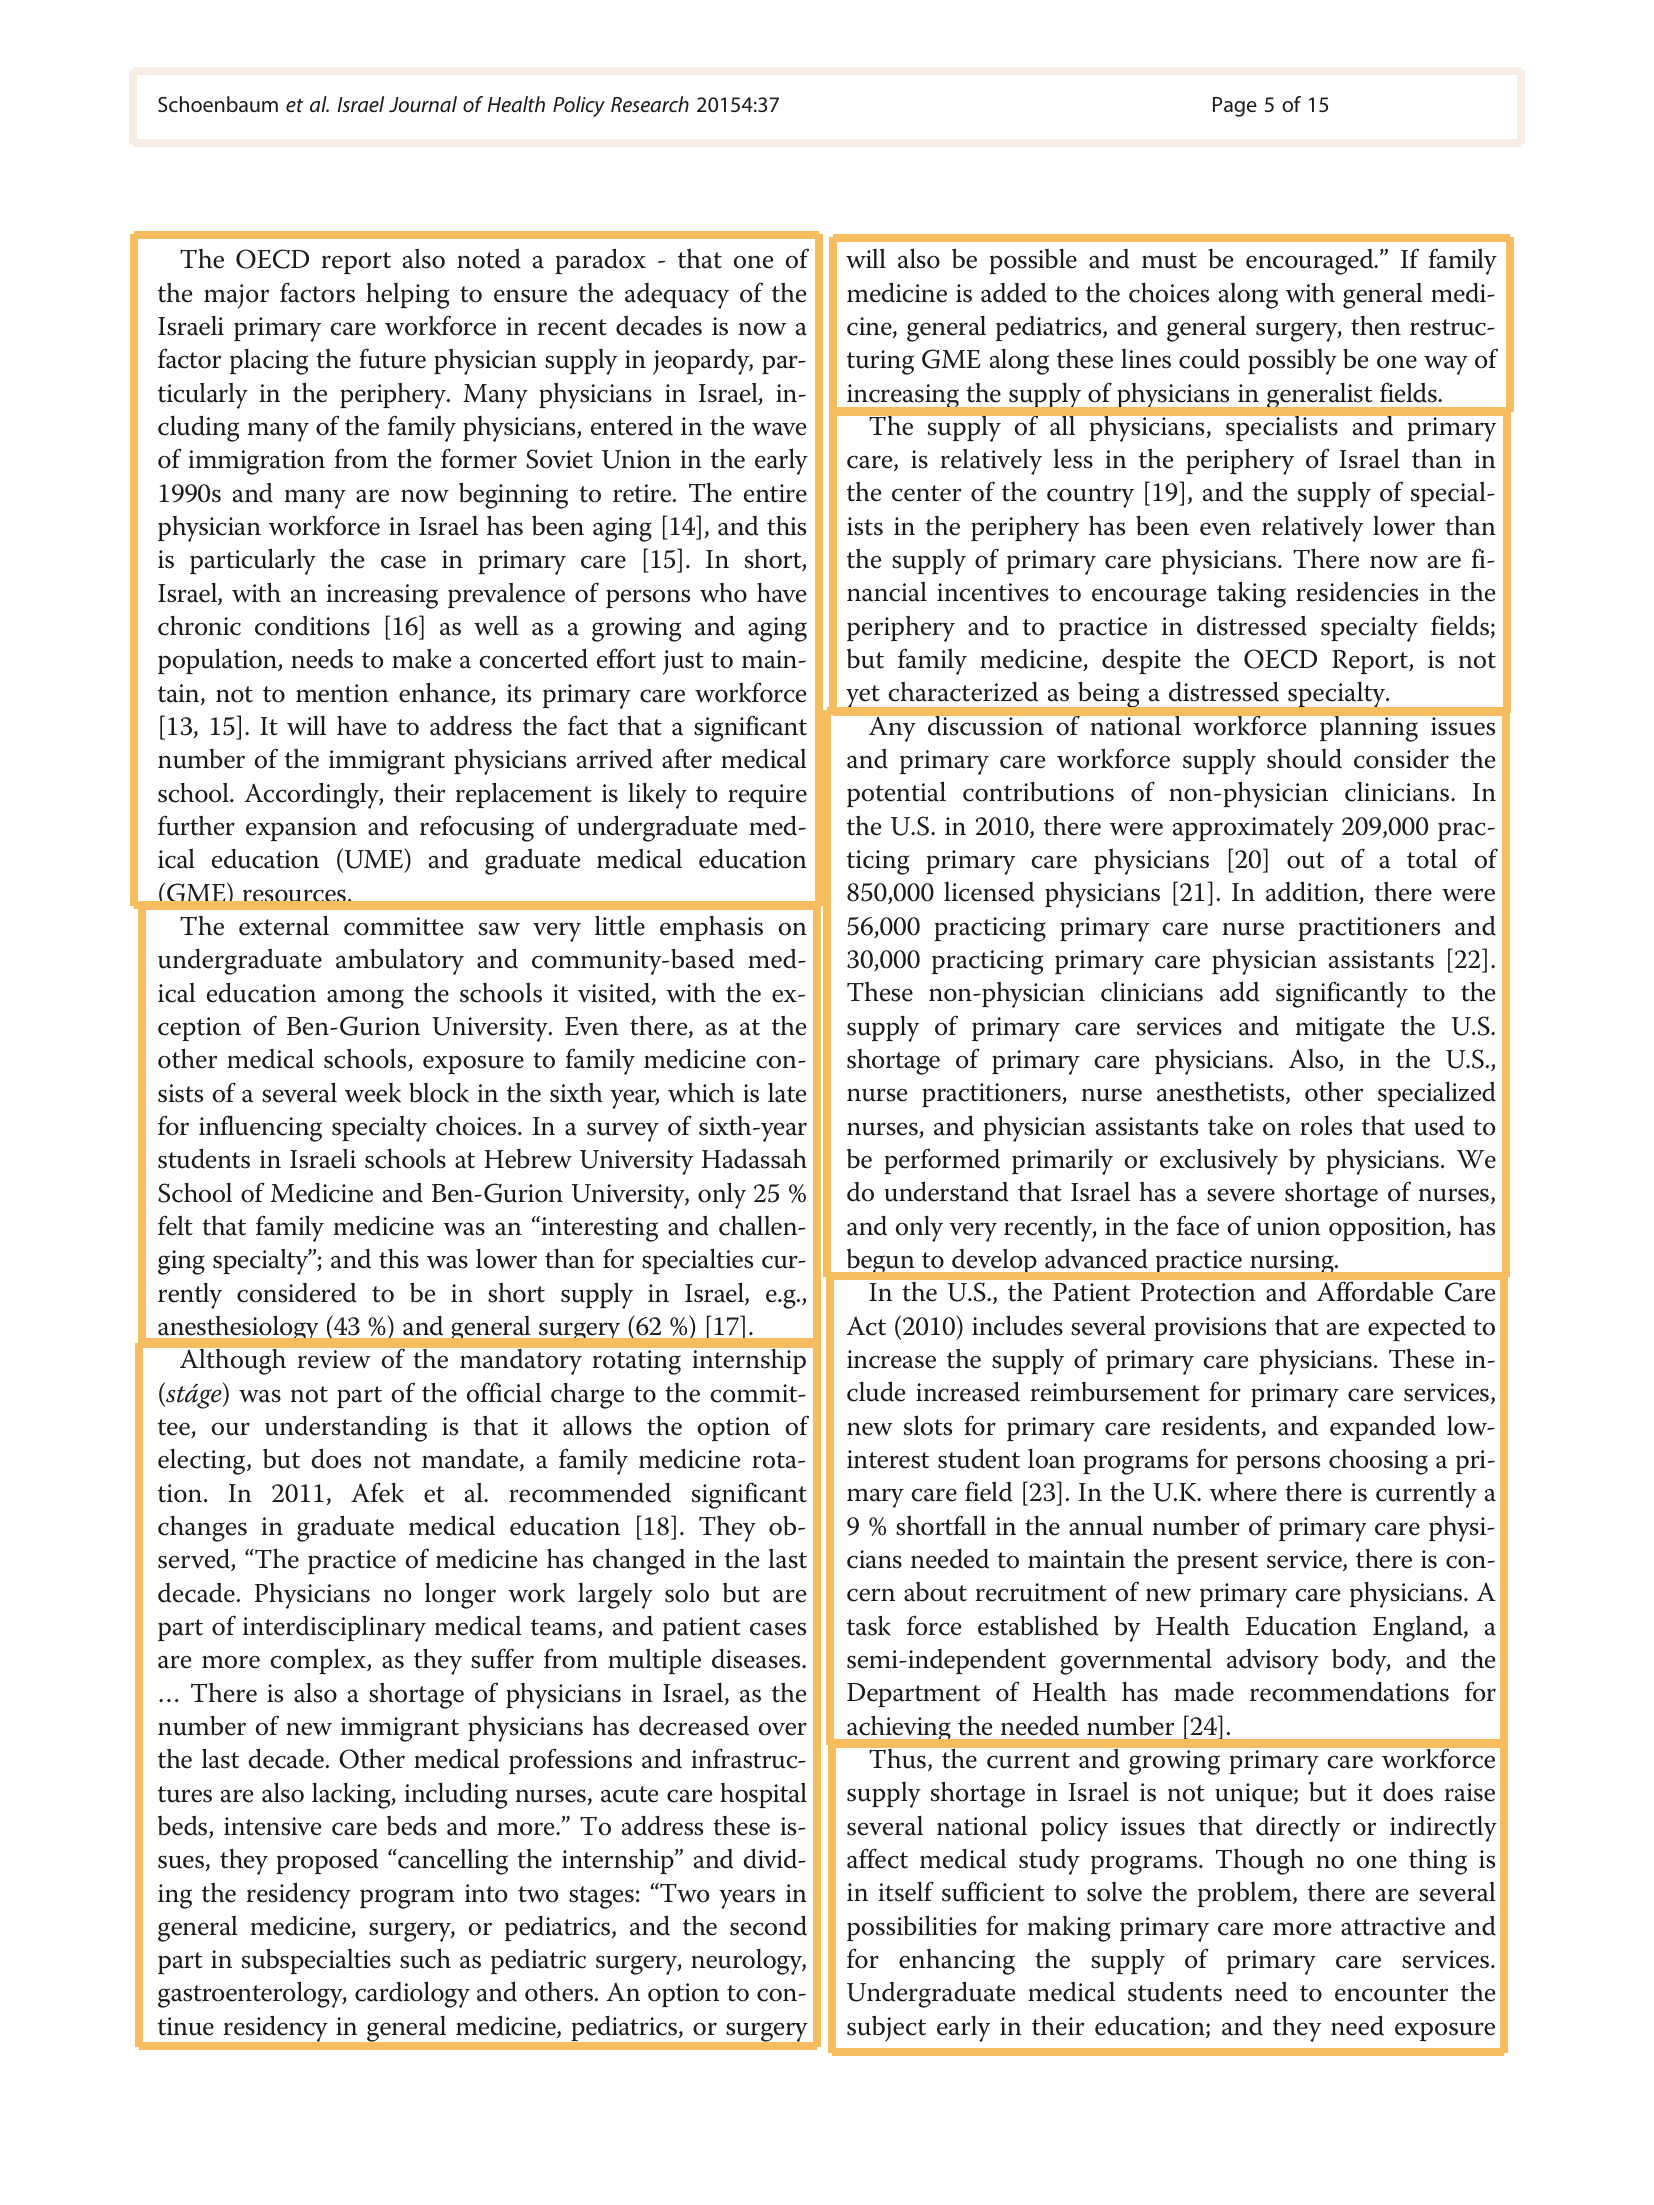

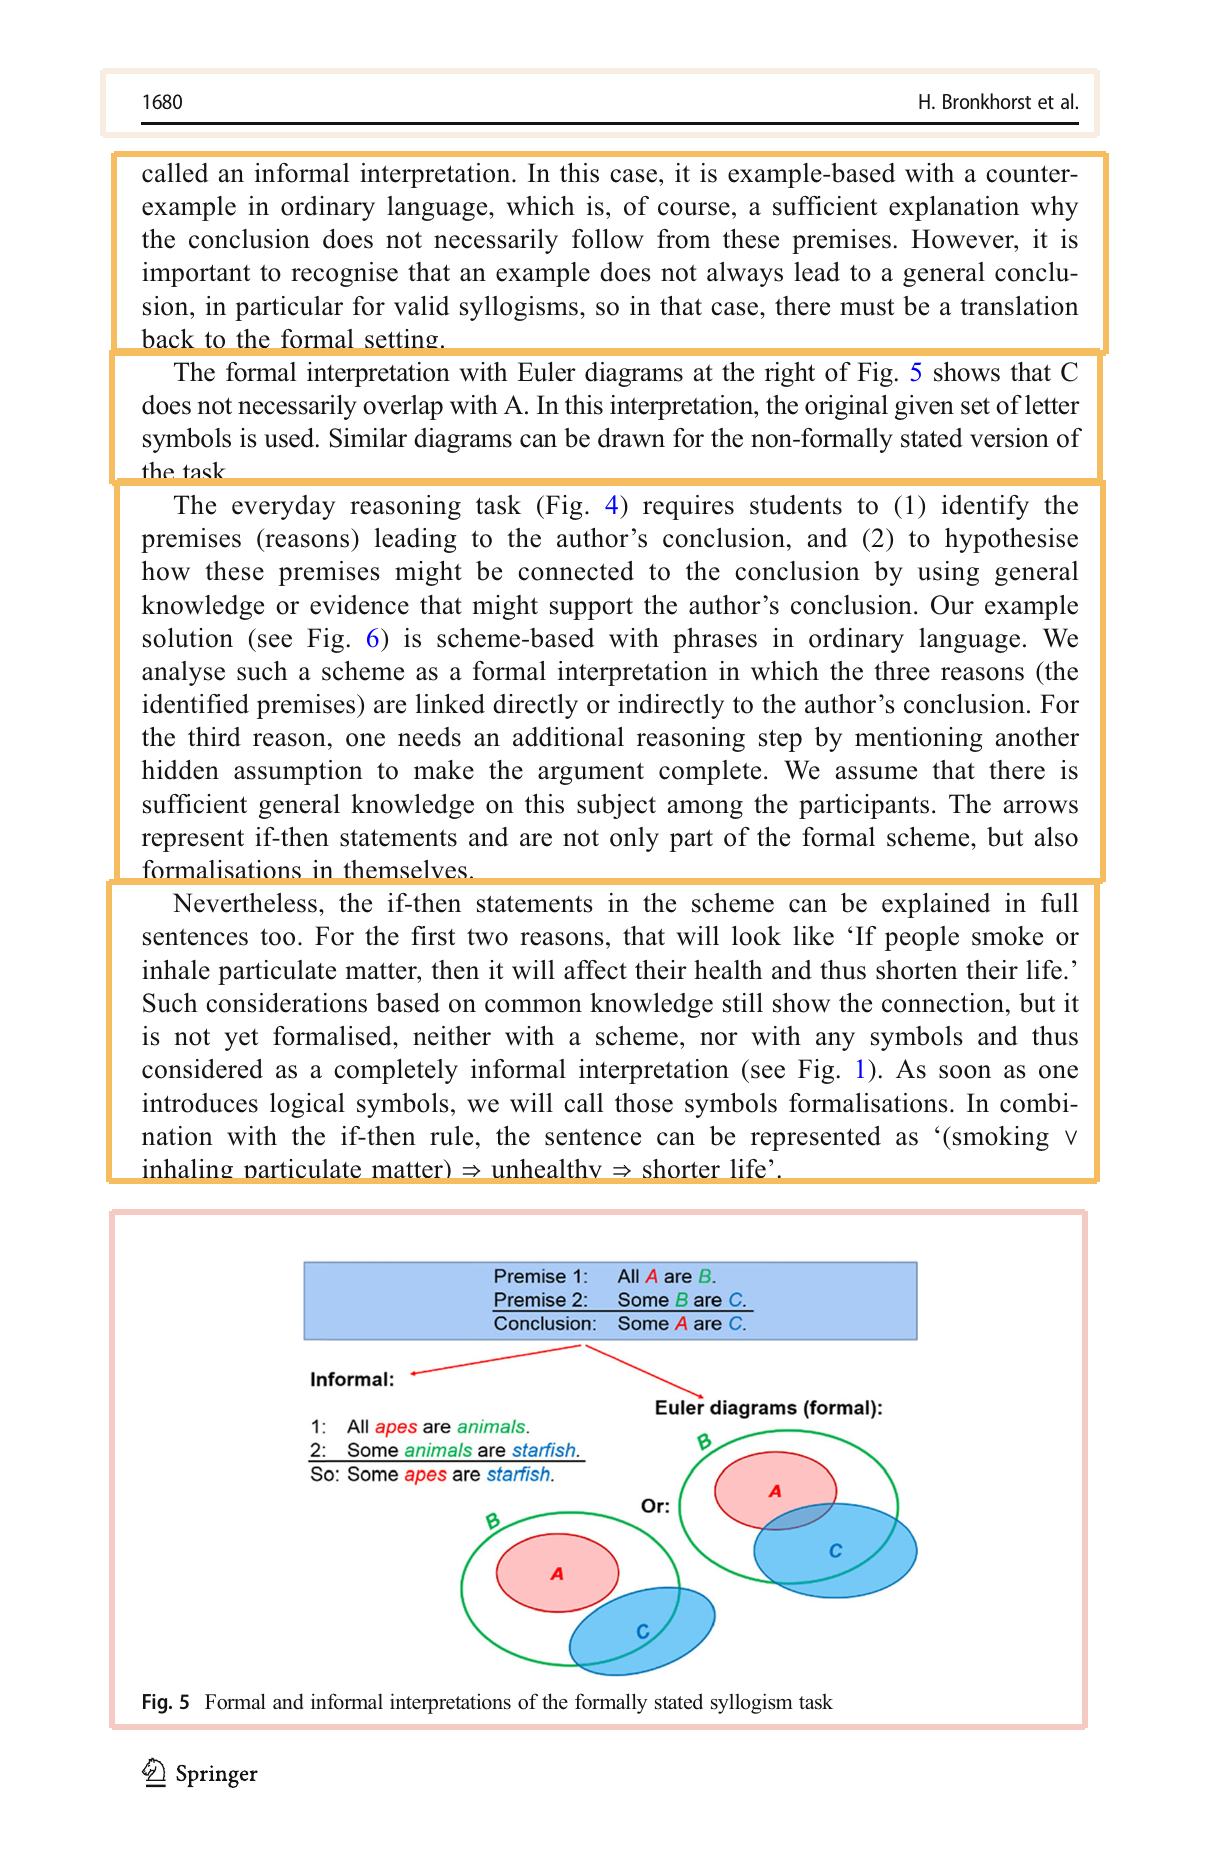

In [6]:
for image_id in random.sample(list(coco.imgs.keys()), 2):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    # Clean up filename - replace Windows backslashes with forward slashes
    clean_filename = image_info["file_name"].replace('\\', '/')

  # Remove both forward- and backslash duplicates
    clean_filename = clean_filename.replace('images/images', 'images').replace('images\\images', 'images')

    if clean_filename.startswith("images/"):
        clean_filename = clean_filename[7:]

    image_path = os.path.join(IMAGE_DIR, clean_filename)

    # Normalize the final path
    image_path = os.path.normpath(image_path)

    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_path} not found.")
        print(f"Attempting to find file at: {os.path.abspath(image_path)}")
        continue

    layout = load_coco_annotations(annotations, coco)
    viz = lp.draw_box(image[..., ::-1], layout)
    
    display(viz)

In [7]:
import json

# Load the annotation file
ORIGINAL_ANNOTATION
with open(ORIGINAL_ANNOTATION, "r") as f:
# with open(annotation_file, "r") as f:
    data = json.load(f)

# Extract the categories
categories = data.get("categories", [])
num_classes = len(categories)

print(f"Number of classes (NUM_CLASSES): {num_classes}")
print("Class Names:")
for category in categories:
    print(f" - ID: {category['id']}, Name: {category['name']}")


Number of classes (NUM_CLASSES): 9
Class Names:
 - ID: 0, Name: Abstract
 - ID: 1, Name: Author
 - ID: 2, Name: Context
 - ID: 3, Name: Header
 - ID: 4, Name: Image
 - ID: 5, Name: Reference
 - ID: 6, Name: Sub_title
 - ID: 7, Name: Table
 - ID: 8, Name: Title


# Train/Test split

In [8]:
# We create train.json and test.json with 85/15 split
TRAIN_RATIO = 0.9
TRAIN_JSON = "train.json"
TEST_JSON = "test.json"

with open(ORIGINAL_ANNOTATION, "r") as f:
    coco_data = json.load(f)

images = coco_data["images"]
annotations = coco_data["annotations"]

# Shuffle images
random.shuffle(images)

split_index = int(TRAIN_RATIO * len(images))
train_images = images[:split_index]
test_images = images[split_index:]

train_image_ids = {img["id"] for img in train_images}
test_image_ids = {img["id"] for img in test_images}

train_annotations = []
test_annotations = []

for ann in annotations:
    if ann["image_id"] in train_image_ids:
        train_annotations.append(ann)
    elif ann["image_id"] in test_image_ids:
        test_annotations.append(ann)

train_coco = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": coco_data["categories"]
}

test_coco = {
    "images": test_images,
    "annotations": test_annotations,
    "categories": coco_data["categories"]
}

with open(TRAIN_JSON, "w") as f:
    json.dump(train_coco, f, indent=2)
with open(TEST_JSON, "w") as f:
    json.dump(test_coco, f, indent=2)

print(f"Train set: {len(train_images)} images, {len(train_annotations)} annotations")
print(f"Test set:  {len(test_images)} images, {len(test_annotations)} annotations")

Train set: 152 images, 1200 annotations
Test set:  17 images, 132 annotations


In [9]:
import torch

print("PyTorch version:", torch.__version__)
print("PyTorch installation path:", torch.__file__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1
PyTorch installation path: /Users/shawnyang/miniconda/envs/tensorflow/lib/python3.9/site-packages/torch/__init__.py
CUDA available: False


In [10]:
import detectron2
from layoutparser.models import Detectron2LayoutModel
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [19]:
#detectron2.utils.collect_env

In [11]:
# Define the paths to the config and model files
config_path = "project-2-at-2024-11-16-22-19-c9fbe515/config.yaml"
model_path = "project-2-at-2024-11-16-22-19-c9fbe515/model_final.pkl"


Load and Fix the result.json File - backslashes


# Register Datasets

In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

def register_my_coco_dataset(name, annotation_json, image_root):
    # Fix image paths in the annotation file
    with open(annotation_json, "r") as f:
        data = json.load(f)
    
    # Clean up image paths
    for img in data["images"]:
        # Remove duplicate 'images' folder and normalize path separators
        clean_path = img["file_name"].replace("\\", "/")
        if "images/images" in clean_path:
            clean_path = clean_path.replace("images/images", "images")
        if clean_path.startswith("images/"):
            clean_path = clean_path[7:]  # Remove leading "images/"
        img["file_name"] = clean_path

    # Write back the fixed annotations
    with open(annotation_json, "w") as f:
        json.dump(data, f)

    # Register the dataset
    if name in DatasetCatalog:
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    register_coco_instances(name, {}, annotation_json, image_root)

TRAIN_NAME = "my_dataset_train"
TEST_NAME = "my_dataset_test"

register_my_coco_dataset(TRAIN_NAME, TRAIN_JSON, IMAGE_DIR)
register_my_coco_dataset(TEST_NAME, TEST_JSON, IMAGE_DIR)

# Quick check
train_dicts = DatasetCatalog.get(TRAIN_NAME)
test_dicts = DatasetCatalog.get(TEST_NAME)

print(f"Registered dataset '{TRAIN_NAME}' with {len(train_dicts)} images")
print(f"Registered dataset '{TEST_NAME}' with {len(test_dicts)} images")

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Users/shawnyang/miniconda/envs/tensorflow/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Users/shawnyang/miniconda/envs/tensorflow/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Registered dataset 'my_dataset_train' with 152 images
Registered dataset 'my_dataset_test' with 17 images


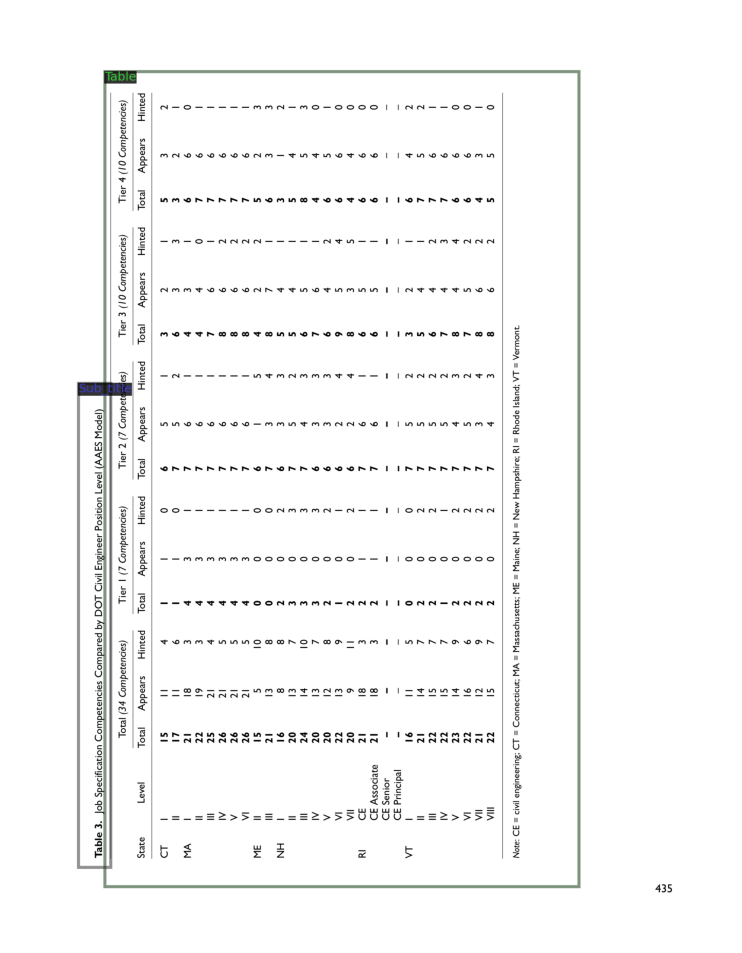

In [13]:
sample = random.choice(train_dicts)
img_path = sample["file_name"]
img = cv2.imread(img_path)
if img is None:
    print(f"Cannot read image: {img_path}")
else:
    metadata = MetadataCatalog.get(TRAIN_NAME)
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_dataset_dict(sample)
    plt.figure(figsize=(12, 8), dpi=150)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

In [14]:
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.modeling.roi_heads import FastRCNNOutputLayers
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.modeling.box_regression import Box2BoxTransform
from torch.optim import AdamW

import os

# Setup logger
setup_logger(output="project-2-at-2024-11-16-22-19-c9fbe515/training_logs.txt")

# Define a custom trainer that uses AdamW
class AdamWTrainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        params = []
        for key, value in model.named_parameters():
            if not value.requires_grad:
                continue
            weight_decay = cfg.SOLVER.WEIGHT_DECAY
            if "norm" in key or "bias" in key:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_NORM
            params += [{"params": [value], "weight_decay": weight_decay}]
        
        return AdamW(
            params,
            lr=cfg.SOLVER.BASE_LR,
            betas=(0.9, 0.999),
            weight_decay=cfg.SOLVER.WEIGHT_DECAY,
        )

cfg = get_cfg()
cfg.merge_from_file("project-2-at-2024-11-16-22-19-c9fbe515/config.yaml")

# We set the train/test sets
cfg.DATASETS.TRAIN = (TRAIN_NAME, )
cfg.DATASETS.TEST = (TEST_NAME, )

# Make sure our train.json/test.json categories are the same as the config
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9

cfg.MODEL.WEIGHTS = "project-2-at-2024-11-16-22-19-c9fbe515/model_final.pkl"
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RPN"
# Force anchor box regression weights
# cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = [10., 10., 5., 5.]
# cfg.SOLVER.OPTIMIZER = "ADAMW"  # Try AdamW instead of SGD
# # cfg.SOLVER.WEIGHT_DECAY = 0.05  # Add regularization to prevent overfitting
# cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True  # Enable gradient clipping
# cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0

# cfg.SOLVER.IMS_PER_BATCH = 6       
# cfg.SOLVER.BASE_LR = 0.00008         
# cfg.SOLVER.MAX_ITER = 80000       
# cfg.SOLVER.CHECKPOINT_PERIOD = 8000

# These will override config.yaml settings
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = [10., 10., 5., 5.]
# cfg.SOLVER.OPTIMIZER = "ADAMW"
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
cfg.SOLVER.IMS_PER_BATCH = 6       
cfg.SOLVER.BASE_LR = 0.00008  # Note: This is lower than your YAML (0.0001)
cfg.SOLVER.MAX_ITER = 80000
cfg.SOLVER.CHECKPOINT_PERIOD = 8000

cfg.OUTPUT_DIR = "./output"
# trainer = AdamWTrainer(cfg)
cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True

In [ ]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AdamWTrainer(cfg)(cfg)
trainer.resume_or_load(resume=False)
print("Starting training...")
trainer.train()

print("Training completed!")


[03/13 12:02:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.con

Starting training...
[03/13 12:02:26 d2.engine.train_loop]: Starting training from iteration 0


e:\Anaconda1\envs\langchain\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/13 12:02:50 d2.utils.events]:  eta: 6:10:26  iter: 19  total_loss: 3.511  loss_cls: 2.253  loss_box_reg: 0.001974  loss_rpn_cls: 0.7018  loss_rpn_loc: 0.5533    time: 0.9294  last_time: 0.7420  data_time: 0.1496  last_data_time: 0.0043   lr: 1.9081e-05  max_mem: 8233M
[03/13 12:03:05 d2.utils.events]:  eta: 6:07:38  iter: 39  total_loss: 2.367  loss_cls: 1.107  loss_box_reg: 0.00149  loss_rpn_cls: 0.6951  loss_rpn_loc: 0.5093    time: 0.8277  last_time: 0.7273  data_time: 0.0041  last_data_time: 0.0044   lr: 3.9061e-05  max_mem: 8233M
[03/13 12:03:19 d2.utils.events]:  eta: 6:06:32  iter: 59  total_loss: 1.441  loss_cls: 0.1746  loss_box_reg: 0.001224  loss_rpn_cls: 0.6767  loss_rpn_loc: 0.5897    time: 0.7957  last_time: 0.7277  data_time: 0.0044  last_data_time: 0.0037   lr: 5.9041e-05  max_mem: 8233M
[03/13 12:03:34 d2.utils.events]:  eta: 6:07:09  iter: 79  total_loss: 1.396  loss_cls: 0.1812  loss_box_reg: 0.002707  loss_rpn_cls: 0.6468  loss_rpn_loc: 0.5603    time: 0.7811  l

In [15]:
import cv2
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

# 1. Build config and load trained weights
cfg = get_cfg()
cfg.merge_from_file("project-2-at-2024-11-16-22-19-c9fbe515/config.yaml")

# Point this to your final trained model in the output folder:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"

# Set the threshold for how confident predictions need to be
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# cfg.MODEL.ROI_BOX_HEAD.CLS.AGNOSTIC_BBOX_REG = True
cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True

/Users/shawnyang/miniconda/envs/tensorflow/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, ma

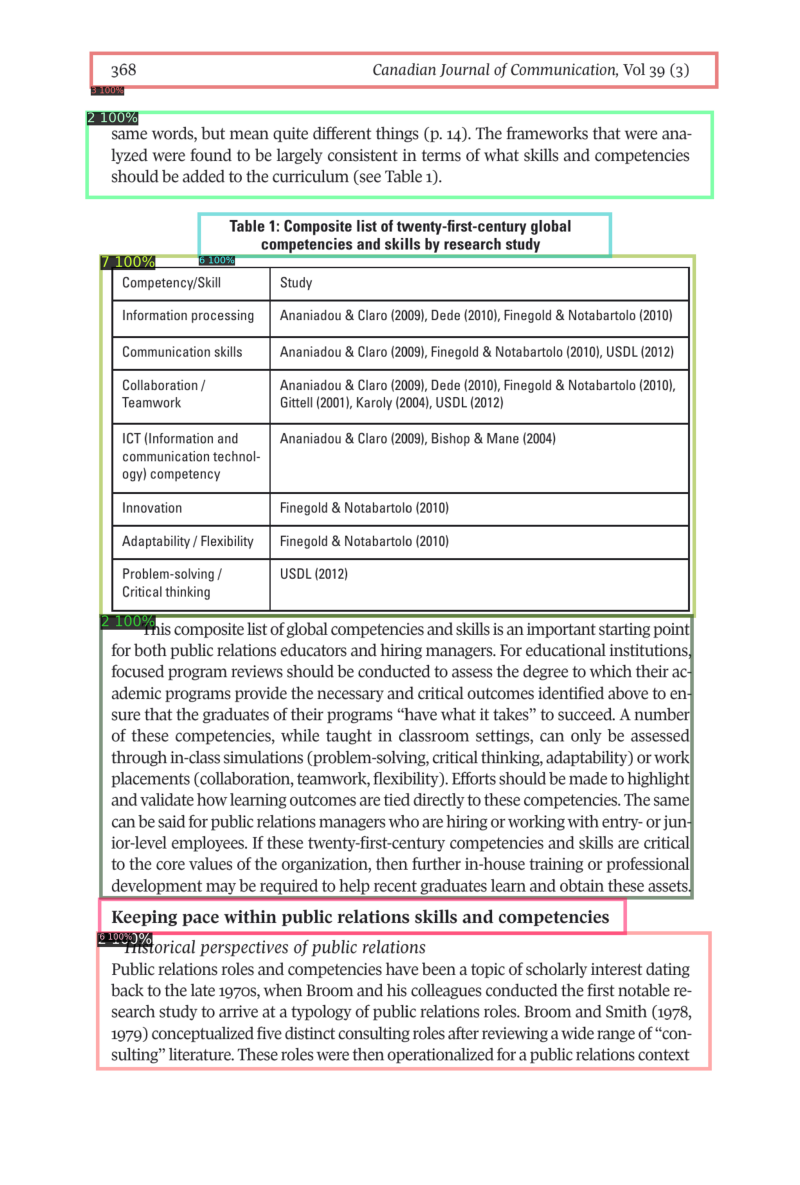

In [16]:
cfg.MODEL.ROI_HEADS.CLASS_AGNOSTIC_BBOX_REG = True
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)

# 2. Inference on one image
# test_image_path = "E:/UofT/work study/project-2-at-2024-11-16-22-19-c9fbe515/images/e423fcb2-SANCHEZ-CABALLE_2021_page_6.png"
# test_image_path = "E:/UofT/work study/project-2-at-2024-11-16-22-19-c9fbe515/images/3d609643-SOULE_2015_page_7.png"
test_image_path = "project-2-at-2024-11-16-22-19-c9fbe515/images/f5ba9f8a-FLYNN_2014_page_9_1.png"
im = cv2.imread(test_image_path)
outputs = predictor(im)

# 'outputs' is a dict; for instance detection, we have:
# outputs["instances"] -> boxes, scores, classes

# 3. Visualization
v = Visualizer(im[:, :, ::-1], scale=2.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(12, 10), dpi=150)
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

# Change Sorting and Store

In [17]:
import torch
from torchvision.ops import nms

def custom_nms_or_filter(boxes, scores, classes, iou_thresh=0.3):
    """
    1) Convert boxes & scores to torch tensors
    2) Use built-in nms to keep only the highest-scoring box in each overlap region
    3) Return indices of the boxes to keep
    """
    boxes_t = torch.tensor(boxes, dtype=torch.float32)
    scores_t = torch.tensor(scores, dtype=torch.float32)
    keep = nms(boxes_t, scores_t, iou_thresh)
    # 'keep' is the set of indices we keep
    return keep.numpy()


In [ ]:
import shutil
import cv2
import pandas as pd
import pytesseract
import tempfile
# pytesseract.pytesseract.tesseract_cmd = r"C:\Users\Shallow\Tesseract\\tesseract.exe"
import re
import numpy as np
import pytesseract
from detectron2.utils.visualizer import Visualizer, ColorMode
from PIL import Image


def correct_image_rotation_cv2(img, page_name="Unknown"):
    """
    Detects the rotation angle with pytesseract's OSD and corrects the image orientation.
    Also prints out the page name along with detected rotation information.
    
    Args:
        img: OpenCV image (BGR format).
        page_name: Name of the current page or image file (for logging).
    
    Returns:
        Rotated OpenCV image in BGR format.
    """
    try:
        # Convert to PIL image for pytesseract
        pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        osd = pytesseract.image_to_osd(pil_img)
        angle = int(re.search(r'(?<=Rotate: )\d+', osd).group(0))
        print(f"[{page_name}] Detected rotation: {angle} degrees")
        if angle != 0:
            corrected = pil_img.rotate(-angle, expand=True)
            corrected_cv2 = cv2.cvtColor(np.array(corrected), cv2.COLOR_RGB2BGR)
            print(f"[{page_name}] Rotated image by {-angle} degrees.")
            return corrected_cv2
    except Exception as e:
        print(f"Warning: could not detect/adjust rotation for {page_name}: {e}")
    return img

def ocr_with_tempfile(crop, custom_config):
    """
    Write crop to a temporary file and perform OCR.
    
    Args:
        crop: Cropped image (numpy array).
        custom_config: Tesseract OCR configuration string.
        
    Returns:
        Extracted text (str)
    """
    try:
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
            tmp_filename = tmp.name
        # Write cropped region to temporary file
        cv2.imwrite(tmp_filename, crop)
        # Open the temporary file with PIL and run OCR
        pil_crop = Image.open(tmp_filename)
        text = pytesseract.image_to_string(pil_crop, config=custom_config)
        os.remove(tmp_filename)
        return text
    except Exception as e:
        if os.path.exists(tmp_filename):
            os.remove(tmp_filename)
        raise e
def correct_crop_orientation(crop_bgr):
    """
    Use Tesseract's OSD (orientation & script detection) to see if the
    crop is rotated. If so, rotate it to make text horizontal.
    """
    try:
        # Convert to PIL RGBA
        pil_img = Image.fromarray(cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB))
        osd = pytesseract.image_to_osd(pil_img)
        
        # Extract the "Rotate: X" angle (0, 90, 180, 270)
        angle_match = re.search(r'Rotate: (\d+)', osd)
        if angle_match:
            angle = int(angle_match.group(1))
            
            # Tesseract says e.g. 90, 180, 270
            # We'll rotate *-angle* to correct it
            if angle in [90, 180, 270]:
                # Example: if angle=270, we do pil_img.rotate(-270) which is +90
                rotated = pil_img.rotate(-angle, expand=True)
                return cv2.cvtColor(np.array(rotated), cv2.COLOR_RGB2BGR)
        
    except Exception as e:
        print(f"Warning: OSD failed on crop: {e}")
    
    # If no rotation or an error occurred, just return original
    return crop_bgr

def is_problem_table(x1, y1, x2, y2, image_width, image_height):
    # define any custom rule. For instance:
    box_w = x2 - x1
    box_h = y2 - y1
    # If bounding box is bigger than half the page? or ratio is weird?
    if box_h > 0.7 * image_height or box_w > 0.7 * image_width:
        return True
    # or if it's a known tall ratio
    if box_h / (box_w + 1e-5) > 2.0:  # e.g., more than 2:1 height/width
        return True
    return False

def preprocess_problem_table(crop_bgr):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)

    # 2) Adaptive threshold or Otsu to remove backgrounds
    #    This often helps Tesseract read lines & text in big tables
    #    You can also invert if that helps
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        25, 11
    )

    # 3) (Optional) Morph close if lines are faint
    #    Just a small morphological operation to darken text lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # 4) Attempt orientation detection on the binarized image
    #    Tesseract OSD can handle multiples of 90. If you suspect mild skew,
    #    use a different method (Hough lines, etc.). Here’s a quick example:
    pil_img = Image.fromarray(thresh)
    osd = pytesseract.image_to_osd(pil_img)
    angle_match = re.search(r'Rotate: (\d+)', osd)
    if angle_match:
        angle = int(angle_match.group(1))
        if angle in [90, 180, 270]:
            # rotate
            rotated = pil_img.rotate(-angle, expand=True)
            # convert back to array
            thresh = np.array(rotated)

    return thresh  # return processed grayscale/binary image

def preprocess_table_crop(crop, margin=10, upscale_factor=2):
    """
    Preprocess a table crop for better OCR.
    
    Steps:
      1. Add a white border (margin) around the crop.
      2. Upscale the crop to enhance small text details.
      3. Convert to grayscale.
      4. Apply a bilateral filter to reduce noise while keeping edges.
      5. Apply adaptive thresholding to obtain a clean binary image.
      
    Args:
        crop: The table crop (numpy array).
        margin: Pixels of white padding to add.
        upscale_factor: Factor to upscale the image dimensions.
        
    Returns:
        Preprocessed image ready for OCR.
    """
    # Add a white border
    padded = cv2.copyMakeBorder(crop, margin, margin, margin, margin,
                                cv2.BORDER_CONSTANT, value=[255, 255, 255])
    # Upscale the image
    upscaled = cv2.resize(padded, None, fx=upscale_factor, fy=upscale_factor,
                          interpolation=cv2.INTER_CUBIC)
    # Convert to grayscale
    gray = cv2.cvtColor(upscaled, cv2.COLOR_BGR2GRAY)
    # Apply bilateral filter to denoise while preserving edges
    filtered = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
    # Adaptive thresholding for better contrast
    thresh = cv2.adaptiveThreshold(filtered, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    return thresh

In [ ]:

CLASS_NAME_MAPPING = {
    0: "Abstract",
    1: "Author",
    2: "Context",
    3: "Header",
    4: "Image",
    5: "Reference",
    6: "Sub_title",
    7: "Table",
    8: "Title"
}


def parse_images(
    input_folder,
    output_folder,
    selected_categories=[],    # e.g. ["Abstract", "Title"] or "All"
    score_threshold=0.8
):

    cfg = get_cfg()
    cfg.merge_from_file("E:/UofT/work study/project-2-at-2024-11-16-22-19-c9fbe515/config.yaml")
    cfg.MODEL.WEIGHTS = "./output/model_final.pth"  
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_threshold
    predictor = DefaultPredictor(cfg)

    # 2. Determine which categories to parse
    all_cats = set(CLASS_NAME_MAPPING.values())
    if (isinstance(selected_categories, str) and selected_categories.lower() == "all") or (
        isinstance(selected_categories, list) and any(cat.lower() == "all" for cat in selected_categories)
    ):
        chosen_cats = all_cats 
    else:
        # ensure they're valid
        chosen_cats = set(selected_categories).intersection(all_cats)
        if not chosen_cats:
            raise ValueError(
                f"None of the selected_categories {selected_categories} match known categories {all_cats}"
            )
        
    folder_name = os.path.basename(input_folder)  
    if folder_name.endswith("_images"):
        folder_name = folder_name[: -len("_images")]  

    # Then create annotated folder
    annotated_folder = f"{folder_name}_annotated_images"
    vis_folder = os.path.join(output_folder, annotated_folder)
    if os.path.exists(vis_folder):
        shutil.rmtree(vis_folder)
    os.makedirs(vis_folder, exist_ok=True)

    # Prepare to store parse results in a single CSV
    parse_results = []

    # 4. Iterate over images in input_folder
    valid_extensions = (".jpg", ".jpeg", ".png")
    image_files = [
        f for f in os.listdir(input_folder)
        if f.lower().endswith(valid_extensions)
    ]

    # Sort the files in natural order
    def natural_sort_key(fname):
        return [int(x) if x.isdigit() else x for x in re.split(r'(\d+)', fname)]
    image_files.sort(key=natural_sort_key)

    for img_name in image_files:
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: cannot read image: {img_path}")
            continue

        # Auto-detect and correct image rotation
        image = correct_image_rotation_cv2(image, page_name=img_name)

        # 4a. Predict
        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes.tensor.numpy()  # (N,4)
        scores = instances.scores.tolist()           # (N,)
        classes = instances.pred_classes.tolist()    # (N,)
        cat_texts = {cat: [] for cat in chosen_cats}

        for i, box in enumerate(boxes):
            class_id = classes[i]
            class_name = CLASS_NAME_MAPPING.get(class_id, "Unknown")
            score_val = scores[i]

            # Skip if below threshold
            if score_val < score_threshold:
                continue

            x1, y1, x2, y2 = box
            crop = image[int(y1):int(y2), int(x1):int(x2)]
            
            # Special handling for Table if user input "all" or "Table"
            if class_name == "Table" and (("all" in [cat.lower() for cat in selected_categories]) or (class_name in chosen_cats)):
                # Decide if this is a problematic table (e.g., tall/big) that needs preprocessing
                if is_problem_table(x1, y1, x2, y2, image.shape[1], image.shape[0]):
                    # apply preprocessing; otherwise, try it anyway.
                    preprocessed_crop = preprocess_table_crop(crop, margin=10, upscale_factor=2)
                    # Optionally, you can try a different PSM for tables with multi-line or multi-column layouts.
                    custom_config = "--psm 4 --oem 3"
                    extracted_text = pytesseract.image_to_string(Image.fromarray(preprocessed_crop),
                                                                config=custom_config)
                    cat_texts["Table"].append(extracted_text)
                else:
                    # Normal OCR for tables
                    custom_config = "--psm 6 --oem 3"
                    extracted_text = pytesseract.image_to_string(
                        Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)),
                        config=custom_config
                    )
                cat_texts["Table"].append(extracted_text)
            # Normal processing for other categories
            elif class_name in chosen_cats:
                custom_config = "--psm 6 --oem 3"
                extracted_text = pytesseract.image_to_string(
                    Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)),
                    config=custom_config
                )
                cat_texts[class_name].append(extracted_text)
            # simple dimension check
            h, w = crop.shape[:2]

            # # Decide if it's a big/tall table
            # if is_problem_table(x1, y1, x2, y2, image.shape[1], image.shape[0]):
            #     # 1) Preprocess
            #     processed = preprocess_problem_table(crop)
                
            #     # 2) OCR
            #     # we pass the processed grayscale/binary to Tesseract
            #     pil_proc = Image.fromarray(processed)  
            #     custom_config = "--psm 6 --oem 3"
            #     extracted_text = pytesseract.image_to_string(pil_proc, config=custom_config)
            # else:
            #     # Normal path for smaller/less tricky tables
            #     # Possibly do a mild orientation fix or your existing code
            #     custom_config = "--psm 6 --oem 3"
            #     extracted_text = pytesseract.image_to_string(
            #         Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)), 
            #         config=custom_config
            #     )

            # cat_texts["Table"].append(extracted_text)


        # for i, box in enumerate(boxes):
        #     class_id = classes[i]
        #     class_name = CLASS_NAME_MAPPING.get(class_id, "Unknown")
        #     score_val = scores[i]

        #     if class_name == "Table" and score_val >= score_threshold:
        #         x1, y1, x2, y2 = box
        #         crop = image[int(y1):int(y2), int(x1):int(x2)]

        #         # 1) Correct the orientation of this bounding-box crop
        #         crop = correct_crop_orientation(crop)

        #         # 2) Now run Tesseract
        #         custom_config = r"--psm 6 --oem 3"
        #         extracted_text = pytesseract.image_to_string(crop, config=custom_config)
        #         cat_texts[class_name].append(extracted_text)

        #     elif class_name in chosen_cats and score_val >= score_threshold:
        #         custom_config = r"--psm 6 --oem 3"
        #         x1, y1, x2, y2 = box
        #         # Crop region
        #         crop = image[int(y1):int(y2), int(x1):int(x2)]
        #         # OCR
        #         extracted_text = pytesseract.image_to_string(crop, config=custom_config)
        #         # extracted_text = pytesseract.image_to_string(crop).strip()
        #         cat_texts[class_name].append(extracted_text)

        # 4c. Visualization for saving annotated image
        v = Visualizer(
            image[:, :, ::-1],
            scale=1.0,
            instance_mode=ColorMode.IMAGE
        )
        out = v.draw_instance_predictions(instances)
        vis_img = out.get_image()[:, :, ::-1]

        # Save the annotated image
        out_path = os.path.join(vis_folder, img_name)
        cv2.imwrite(out_path, vis_img)

        # 4d. Combine all texts for each category
        # e.g., if multiple bounding boxes for 'Abstract', join them with newline
        parse_results.append({
            "filename": img_name,
            **{
                cat: "\n".join(cat_texts[cat])  # combine all extracted texts
                for cat in chosen_cats
            }
        })

    # 5. Save results to a CSV
    df = pd.DataFrame(parse_results)
    csv_path = os.path.join(output_folder, f"{img_name}_parsed_text.csv")
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")

    print(f"Done! Wrote CSV to: {csv_path}")
    print(f"Annotated images are in: {vis_folder}")


In [56]:

SELECTED_CATEGORIES = ["all"]# 

INPUT_FOLDER = "E:/UofT/work study/test/GREENE-CLEMONS_2016_images"
OUTPUT_FOLDER = "E:/UofT/work study/output/parse_output/"

parse_images(
    input_folder=INPUT_FOLDER,
    output_folder=OUTPUT_FOLDER,
    selected_categories=SELECTED_CATEGORIES,
    score_threshold=0.8
)

[03/03 21:55:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


e:\Anaconda1\envs\langchain\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("

[GREENE-CLEMONS_2016_1 (1).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (2).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (3).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (4).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (5).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (6).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (7).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (8).png] Detected rotation: 90 degrees
[GREENE-CLEMONS_2016_1 (8).png] Rotated image by -90 degrees.
[GREENE-CLEMONS_2016_1 (9).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (10).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (11).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (12).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (13).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (14).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_2016_1 (15).png] Detected rotation: 0 degrees
[GREENE-CLEMONS_

In [27]:
# from detectron2.data import DatasetCatalog

# # Check if all images exist
# dataset_dicts = DatasetCatalog.get("my_dataset_train")
# for d in dataset_dicts:
#     if not os.path.isfile(d["file_name"]):
#         print(f"File not found: {d['file_name']}")



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [28]:
# import json

# # Load the annotation file
# with open(annotation_file, "r") as f:
#     data = json.load(f)

# # Extract the categories
# categories = data.get("categories", [])
# num_classes = len(categories)

# print(f"Number of classes (NUM_CLASSES): {num_classes}")
# print("Class Names:")
# for category in categories:
#     print(f" - ID: {category['id']}, Name: {category['name']}")


Number of classes (NUM_CLASSES): 9
Class Names:
 - ID: 0, Name: Abstract
 - ID: 1, Name: Author
 - ID: 2, Name: Context
 - ID: 3, Name: Header
 - ID: 4, Name: Image
 - ID: 5, Name: Reference
 - ID: 6, Name: Sub_title
 - ID: 7, Name: Table
 - ID: 8, Name: Title


In [ ]:
for page_index in []:
    cont_items = model.detect(pdf_images[page_index])
    break

In [ ]:
for cont_item in cont_items:
    cont_tokens = pdf_tokens[page_index].filter_by(cont_item, center=TRUE)
    break

In [ ]:
# to check what's inside each bib_item block?
viz = lp.draw_box(pdf_images[page_index], bib_tokens, color_map={}, box_alpha=0.2, box_width=0)
viz

In [ ]:
lp.draw_box(viz, [cont_item], color_map-{}) # overlay cont_item block tokens onto cont_tokens

In [ ]:
"".join(cont_tokens.get_texts())